<div class="alert alert-block alert-success">
<h3><center style="line-height: 1">MSDS-422: Practical Machine Learning</center></h3>
<h1><center style="line-height: 1">Final Project: Group 5</center></h1>
<h2><center style="line-height: 1">Identifying Malware in Network Traffic with Supervised Learning</center></h2>

<b>Group 5</b>:
<ul>
    <li>Aishwarya Mathuria</li>
    <li>Akshaya Venkat Raman</li>
    <li>Tanmay Swami</li>
    <li>Yatika Taneja</li>
</ul>
</div>

In [123]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import glob
from datetime import datetime
import ipaddress
from collections import Counter
from scipy import stats
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Load Dataset</h1>
</div>

In [124]:
# Load all CSV files without any cleaning
print("Loading raw data")
csv_files = glob.glob('data/*.csv')
print(f"Found {len(csv_files)} CSV files:")
for file in sorted(csv_files):
    size_mb = Path(file).stat().st_size / (1024 * 1024)
    print(f"  - {file}: {size_mb:.2f} MB")

all_dataframes = []

for file in csv_files:
    try:
        print(f"Loading {file}...")
        df = pd.read_csv(file, sep='|')
        all_dataframes.append(df)
        print(f"  - Loaded {len(df)} records")
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not all_dataframes:
    raise ValueError("No data files could be loaded")

df = pd.concat(all_dataframes, ignore_index=True)
print(f"\nCombined raw dataset shape: {df.shape}")

# df['label'] = df.apply(
#     lambda row: f"{row['label']} {row['detailed-label']}" if ((row['label'] != 'Benign') and row['detailed-label'] != 'nan') else 'Benign',
#     axis=1
# )

# Drop detailed-label column
if 'detailed-label' in df.columns:
    df.drop(columns=['detailed-label'], inplace=True)

print("\nUpdated label distribution:")
print(df['label'].value_counts())

numeric_cols = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

Loading raw data
Found 1 CSV files:
  - data/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv: 132.06 MB
Loading data/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv...
  - Loaded 1008748 records

Combined raw dataset shape: (1008748, 23)

Updated label distribution:
label
Malicious    539473
Benign       469275
Name: count, dtype: int64


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Exploratory Data Analysis</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Basic dataset Information</h3>
</div>

In [125]:
print("\n")
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"Shape: {df.shape}")
df.info(memory_usage='deep')
print("\n")



Total records: 1008748
Total columns: 22
Shape: (1008748, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008748 entries, 0 to 1008747
Data columns (total 22 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ts              1008748 non-null  float64
 1   uid             1008748 non-null  object 
 2   id.orig_h       1008748 non-null  object 
 3   id.orig_p       1008748 non-null  float64
 4   id.resp_h       1008748 non-null  object 
 5   id.resp_p       1008748 non-null  float64
 6   proto           1008748 non-null  object 
 7   service         1008748 non-null  object 
 8   duration        212448 non-null   float64
 9   orig_bytes      212448 non-null   float64
 10  resp_bytes      212448 non-null   float64
 11  conn_state      1008748 non-null  object 
 12  local_orig      1008748 non-null  object 
 13  local_resp      1008748 non-null  object 
 14  missed_bytes    1008748 non-null  float64
 15  history         100

In [126]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label
0,1.525880e+09,CUmrqr4svHuSXJy5z7,192.168.100.103,51524.0,65.127.233.163,23.0,tcp,-,2.999051,0.0,...,-,-,0.0,S,3.0,180.0,0.0,0.0,-,Malicious
1,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305.0,63.150.16.171,23.0,tcp,-,NaN,NaN,...,-,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious
2,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101.0,111.40.23.49,23.0,tcp,-,NaN,NaN,...,-,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious
3,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905.0,131.174.215.147,23.0,tcp,-,2.998796,0.0,...,-,-,0.0,S,3.0,180.0,0.0,0.0,-,Malicious
4,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301.0,91.42.47.63,23.0,tcp,-,NaN,NaN,...,-,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Columns</h3>
</div>

In [127]:
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

Columns:
    1. ts
    2. uid
    3. id.orig_h
    4. id.orig_p
    5. id.resp_h
    6. id.resp_p
    7. proto
    8. service
    9. duration
   10. orig_bytes
   11. resp_bytes
   12. conn_state
   13. local_orig
   14. local_resp
   15. missed_bytes
   16. history
   17. orig_pkts
   18. orig_ip_bytes
   19. resp_pkts
   20. resp_ip_bytes
   21. tunnel_parents
   22. label


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Data types</h3>
</div>

In [128]:
print(df.dtypes.value_counts())

float64    11
object     11
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing values</h3>
</div>

,MissingValues,Percent
duration,796300,78.94
orig_bytes,796300,78.94
resp_bytes,796300,78.94


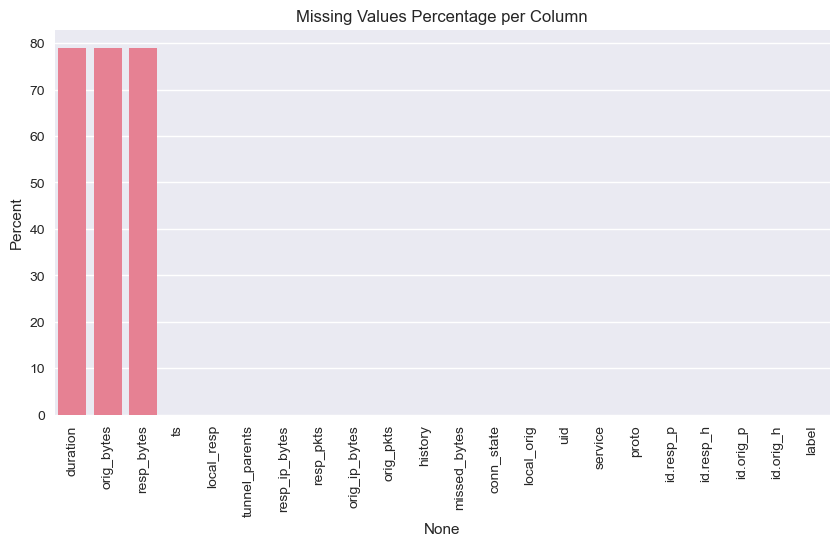

In [129]:
# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'MissingValues': missing, 'Percent': missing_percent})
display(missing_df[missing_df.MissingValues > 0])

# Visualize missing values
plt.figure(figsize=(10,5))
sns.barplot(x=missing_df.index, y=missing_df['Percent'])
plt.xticks(rotation=90)
plt.title("Missing Values Percentage per Column")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value Distribution</h3>
</div>

label
Malicious    539473
Benign       469275
Name: count, dtype: int64


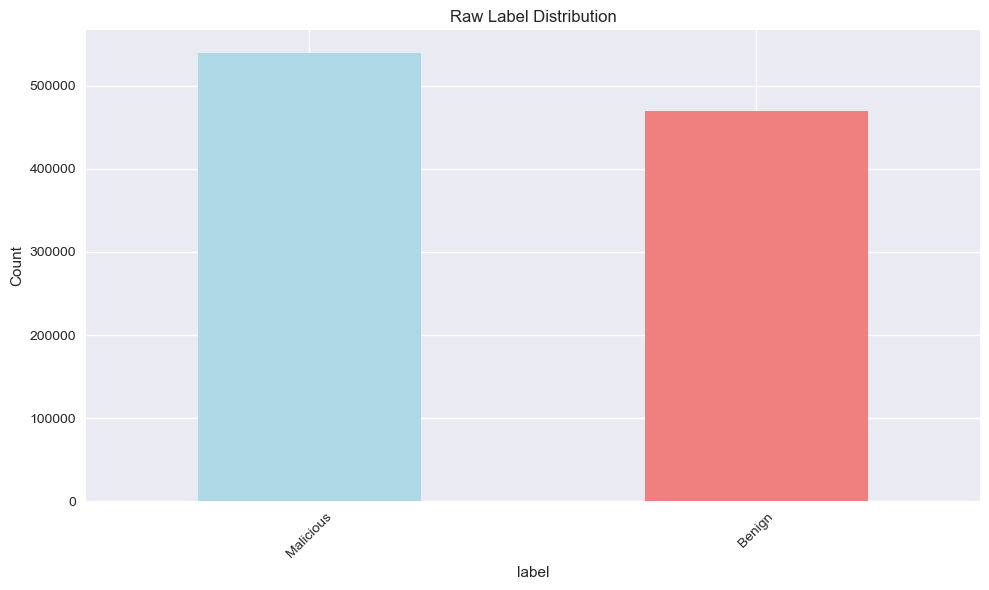

In [130]:
label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Raw Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Histograms for numerical features</h3>
</div>

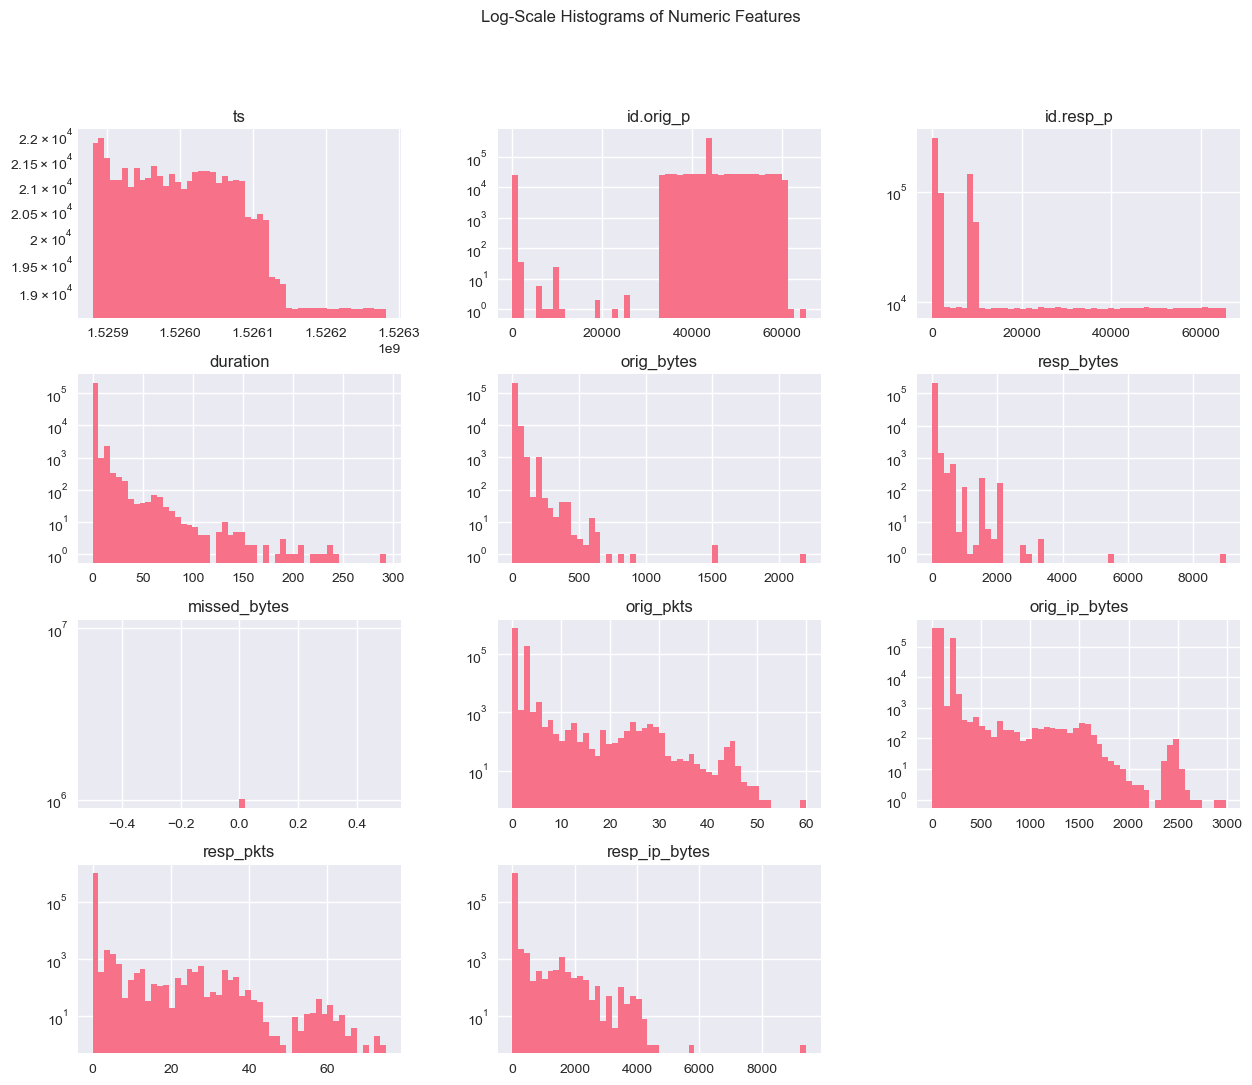

In [131]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(15, 12), bins=50, log=True)
plt.suptitle("Log-Scale Histograms of Numeric Features")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation Heatmap</h3>
</div>

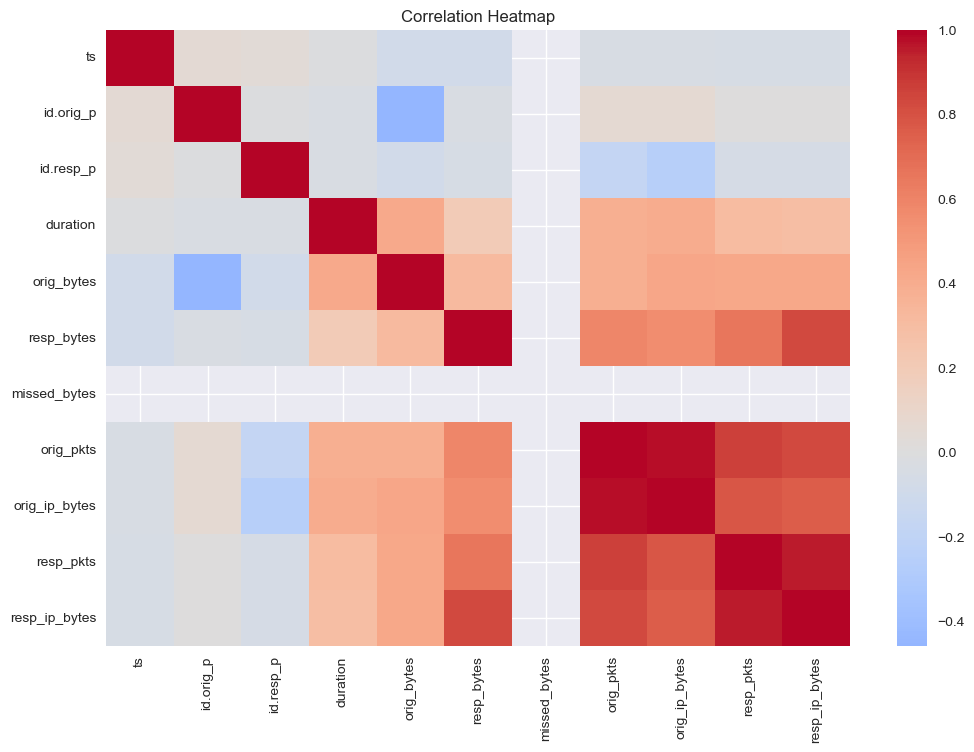

In [132]:
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Boxplots by Label</h3>
</div>

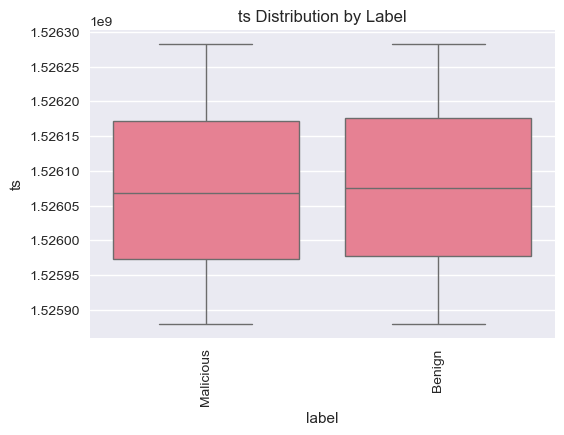

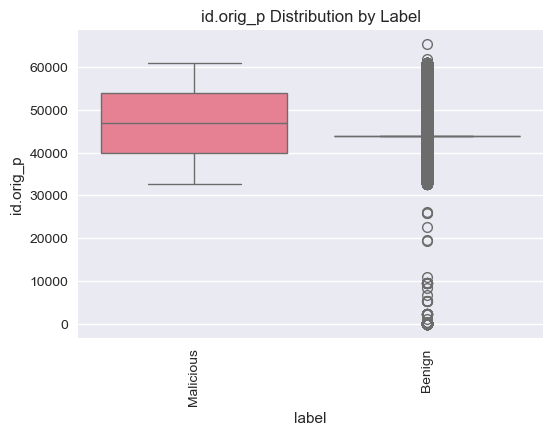

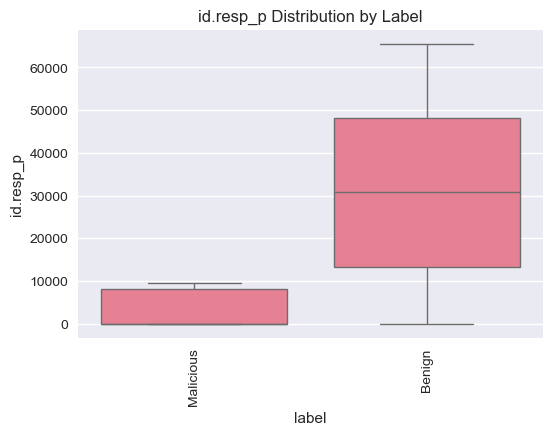

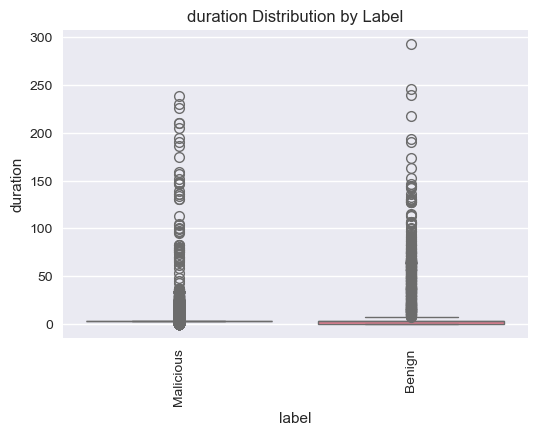

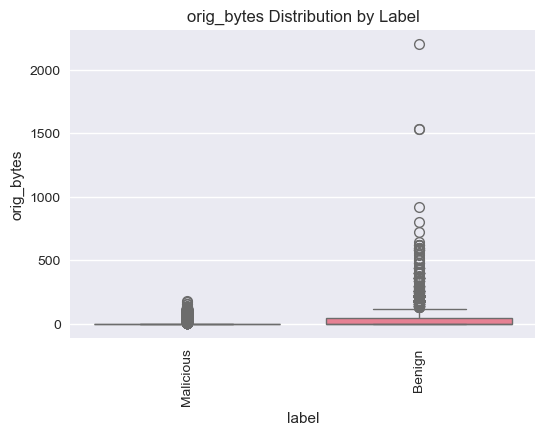

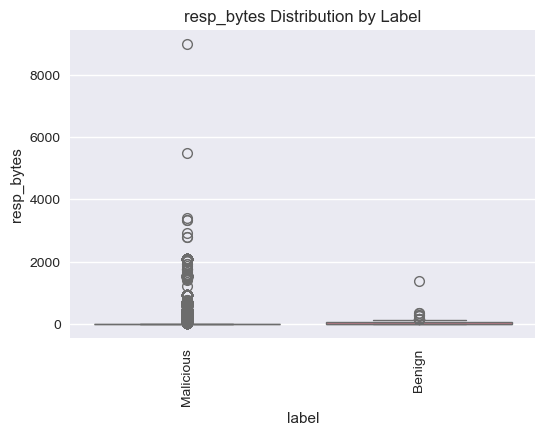

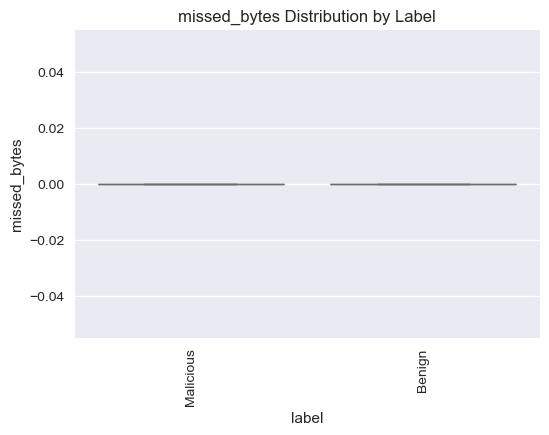

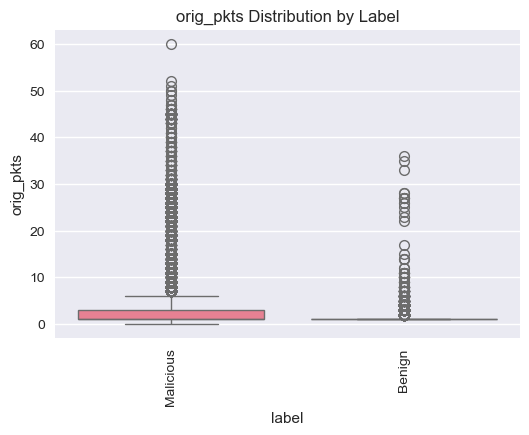

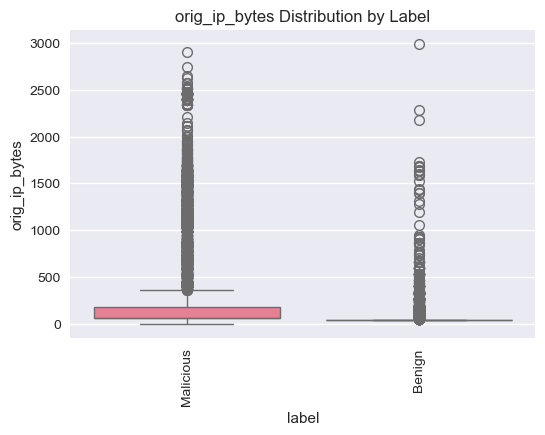

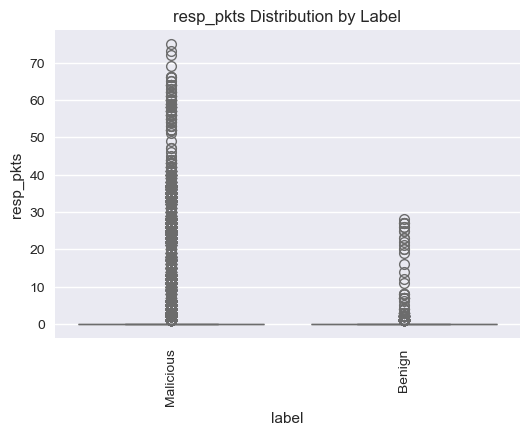

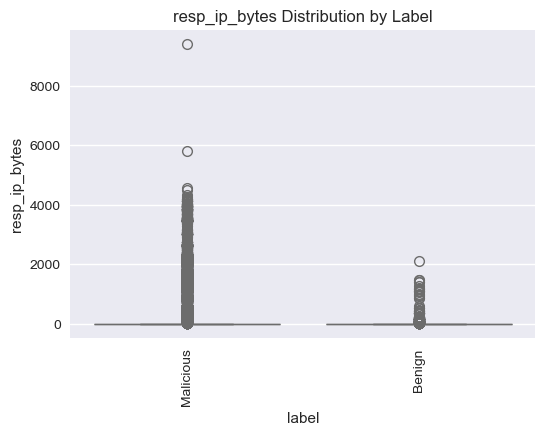

In [133]:
for col in numeric_cols:  # first 5 numeric features
    plt.figure(figsize=(6,4))
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f"{col} Distribution by Label")
    plt.xticks(rotation=90)
    plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Outlier detection</h3>
</div>

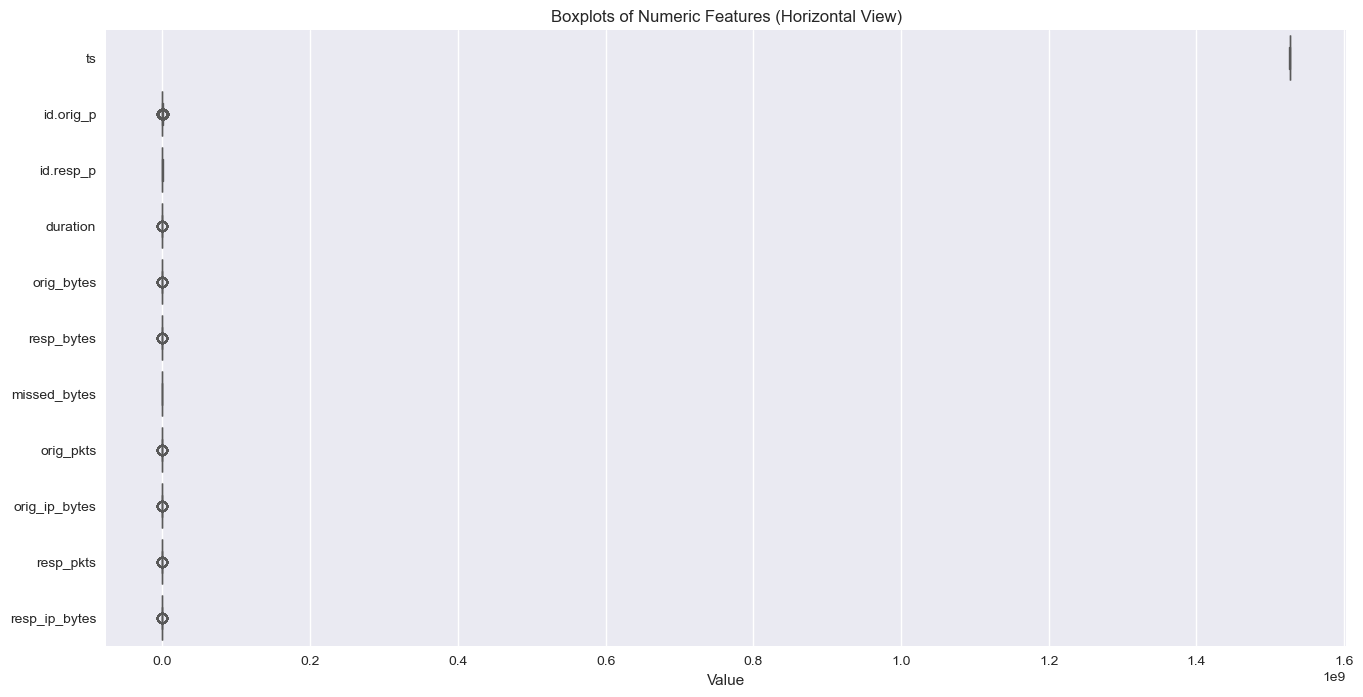

ts: 0 outliers
id.orig_p: 190758 outliers
id.resp_p: 0 outliers
duration: 22966 outliers
orig_bytes: 16937 outliers
resp_bytes: 13629 outliers
missed_bytes: 0 outliers
orig_pkts: 202024 outliers
orig_ip_bytes: 202454 outliers
resp_pkts: 19894 outliers
resp_ip_bytes: 19894 outliers


In [134]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[numeric_cols], orient='h', palette='Set2')
plt.title("Boxplots of Numeric Features (Horizontal View)")
plt.xlabel("Value")
plt.show()

for col in numeric_cols:
    q1, q3 = np.percentile(df[col].dropna(), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outlier_count} outliers")

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Data Cleaning and Preparation</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling missing values</h3>
</div>

In [135]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [136]:
for col in numeric_cols:
    if col in df.columns:
        print(f"Converting {col} to numeric...")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        missing_before = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        missing_after = df[col].isnull().sum()
        print(f"    Missing values: {missing_before} -> {missing_after}")

Converting ts to numeric...
    Missing values: 0 -> 0
Converting id.orig_p to numeric...
    Missing values: 0 -> 0
Converting id.resp_p to numeric...
    Missing values: 0 -> 0
Converting duration to numeric...
    Missing values: 796300 -> 0
Converting orig_bytes to numeric...
    Missing values: 796300 -> 0
Converting resp_bytes to numeric...
    Missing values: 796300 -> 0
Converting missed_bytes to numeric...
    Missing values: 0 -> 0
Converting orig_pkts to numeric...
    Missing values: 0 -> 0
Converting orig_ip_bytes to numeric...
    Missing values: 0 -> 0
Converting resp_pkts to numeric...
    Missing values: 0 -> 0
Converting resp_ip_bytes to numeric...
    Missing values: 0 -> 0


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Feature Engineering</h3>
</div>

In [137]:
print(df.shape)
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

(1008748, 22)
ts: 1008748 unique values
uid: 1008748 unique values
id.orig_h: 15004 unique values
id.orig_p: 28243 unique values
id.resp_h: 597107 unique values
id.resp_p: 65426 unique values
proto: 3 unique values
service: 5 unique values
duration: 16650 unique values
orig_bytes: 170 unique values
resp_bytes: 478 unique values
conn_state: 11 unique values
local_orig: 1 unique values
local_resp: 1 unique values
missed_bytes: 1 unique values
history: 126 unique values
orig_pkts: 54 unique values
orig_ip_bytes: 1249 unique values
resp_pkts: 69 unique values
resp_ip_bytes: 1141 unique values
tunnel_parents: 1 unique values
label: 2 unique values


In [138]:
if {'TotalBytes', 'TotalPackets', 'Duration'}.issubset(df.columns):
    df['BytesPerPacket'] = df['TotalBytes'] / (df['TotalPackets'] + 1)
    df['PacketsPerSecond'] = df['TotalPackets'] / (df['Duration'] + 1e-6)

# Encode Protocols
# if 'Protocol' in df.columns:
#     df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)

# Convert IP addresses to numeric
import ipaddress
def ip_to_int(ip):
    try:
        return int(ipaddress.IPv4Address(ip))
    except:
        return None

for col in ['SourceIP','DestinationIP']:
    if col in df.columns:
        df[col+'_int'] = df[col].apply(ip_to_int)

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Convert timestamp to datetime</h3>
</div>

In [139]:
print("Converting timestamps")
df['timestamp'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
invalid_timestamps = df['timestamp'].isnull().sum()
print(f"    Invalid timestamps: {invalid_timestamps}")

# Adding temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
print("Added hour and day_of_week features")

Converting timestamps
    Invalid timestamps: 0
Added hour and day_of_week features


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling IP addresses and ports</h3>
</div>

In [140]:
print("Processing origin IP addresses...")
df['is_private_orig'] = df['id.orig_h'].apply(lambda x: 
    ipaddress.ip_address(x).is_private if pd.notna(x) else False)

print("Processing response IP addresses...")
df['is_private_resp'] = df['id.resp_h'].apply(lambda x: 
    ipaddress.ip_address(x).is_private if pd.notna(x) else False)

Processing origin IP addresses...
Processing response IP addresses...


In [141]:
# Categorize ports into common service types
def categorize_port(port):
    try:
        port = int(port)
        if port <= 1024:
            return 'well_known'
        elif port <= 49151:
            return 'registered'
        else:
            return 'dynamic'
    except:
        return 'unknown'

print("Categorizing origin ports...")
df['orig_port_category'] = df['id.orig_p'].apply(categorize_port)
    
print("Categorizing response ports...")
df['resp_port_category'] = df['id.resp_p'].apply(categorize_port)

Categorizing origin ports...
Categorizing response ports...


# Columns to Drop (Tanmay)

In [142]:
df.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents', 'label', 'timestamp', 'hour', 'day_of_week',
       'is_private_orig', 'is_private_resp', 'orig_port_category',
       'resp_port_category'],
      dtype='object')

In [143]:
cols_to_drop = []
for col in df.columns:
    if df[col].nunique() < 2:
        cols_to_drop.append(col)
    elif df[col].nunique() == len(df):
        cols_to_drop.append(col)
cols_to_drop.extend(['id.orig_h', 'id.resp_h'])
print(cols_to_drop)
df.drop(columns=cols_to_drop, inplace=True)

['ts', 'uid', 'local_orig', 'local_resp', 'missed_bytes', 'tunnel_parents', 'timestamp', 'id.orig_h', 'id.resp_h']


In [144]:
categorical_cols = df.drop(columns= 'label').select_dtypes(include=['object']).columns

print(df.select_dtypes(exclude=['object']).columns.tolist())
print("-" * 20)
print(categorical_cols)

['id.orig_p', 'id.resp_p', 'duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'hour', 'is_private_orig', 'is_private_resp']
--------------------
Index(['proto', 'service', 'conn_state', 'history', 'day_of_week',
       'orig_port_category', 'resp_port_category'],
      dtype='object')


In [145]:
df[df.select_dtypes(exclude=['object']).columns.tolist() + list(categorical_cols)].head()

,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,hour,is_private_orig,is_private_resp,proto,service,conn_state,history,day_of_week,orig_port_category,resp_port_category
0,51524.0,23.0,2.999051,0.0,0.0,3.0,180.0,0.0,0.0,15,True,False,tcp,-,S0,S,Wednesday,dynamic,well_known
1,56305.0,23.0,0.000000,0.0,0.0,1.0,60.0,0.0,0.0,15,True,False,tcp,-,S0,S,Wednesday,dynamic,well_known
2,41101.0,23.0,0.000000,0.0,0.0,1.0,60.0,0.0,0.0,15,True,False,tcp,-,S0,S,Wednesday,registered,well_known
3,60905.0,23.0,2.998796,0.0,0.0,3.0,180.0,0.0,0.0,15,True,False,tcp,-,S0,S,Wednesday,dynamic,well_known
4,44301.0,23.0,0.000000,0.0,0.0,1.0,60.0,0.0,0.0,15,True,False,tcp,-,S0,S,Wednesday,registered,well_known


In [146]:
for col in df[categorical_cols]:
    print(f"{col}: {df[col].nunique()} unique values : {df[col].unique()[:5]}...")

proto: 3 unique values : ['tcp' 'udp' 'icmp']...
service: 5 unique values : ['-' 'http' 'dhcp' 'ssh' 'dns']...
conn_state: 11 unique values : ['S0' 'REJ' 'SF' 'OTH' 'RSTOS0']...
history: 126 unique values : ['S' 'Sr' 'D' 'Dd' '-']...
day_of_week: 6 unique values : ['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']...
orig_port_category: 3 unique values : ['dynamic' 'registered' 'well_known']...
resp_port_category: 3 unique values : ['well_known' 'dynamic' 'registered']...


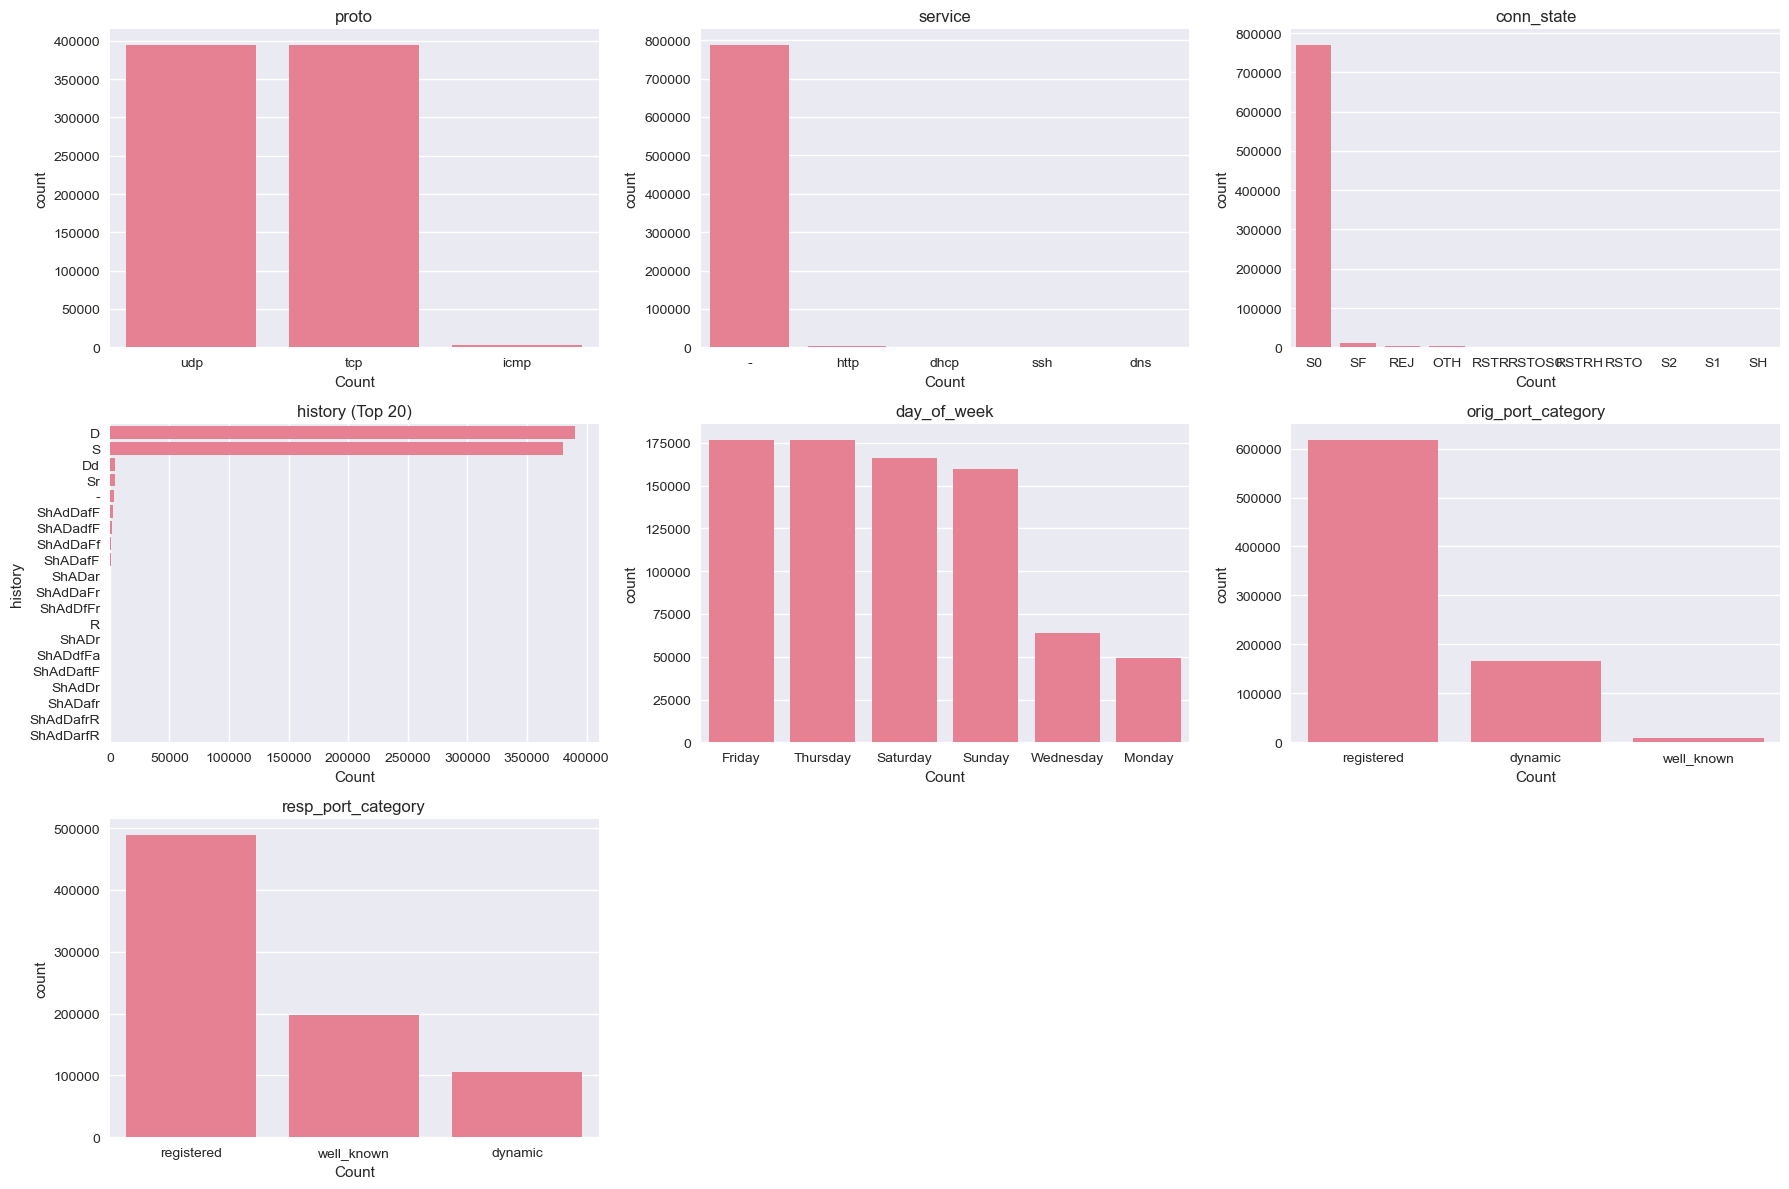

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = [
    'proto', 'service', 'conn_state', 'history', 
    'day_of_week', 'orig_port_category', 'resp_port_category'
]

n_cols = 3  
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(6*n_cols, 4*n_rows))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    if col == 'history':
        top_hist = df[col].value_counts().nlargest(20).index
        plot_data = df[df[col].isin(top_hist)]
        sns.countplot(y=col, data=plot_data, order=top_hist)
        plt.title(f"{col} (Top 20)")
    else:
        sns.countplot(x=col, data=df, order=df[col].value_counts().index)
        plt.title(col)
    plt.xlabel("Count")
    plt.tight_layout()

plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling duplicates</h3>
</div>

In [147]:
duplicates_before = df.duplicated().sum()
df = df.drop_duplicates()
duplicates_after = df.duplicated().sum()
print(f"Removed {duplicates_before - duplicates_after} duplicate rows")

Removed 216894 duplicate rows


# Feature Engineering (Tanmay)

In [149]:
ohe_cols = ['proto', 'service', 'conn_state', 'day_of_week', 'orig_port_category', 'resp_port_category']
df = pd.get_dummies(df, columns=ohe_cols)

In [167]:
#split
X = df.drop(columns=['label'])
y = df['label'] #change accordingly
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [168]:
woe_encoder = ce.WOEEncoder(cols=['history'])
X_train['history_woe'] = woe_encoder.fit_transform(X_train['history'], y_train)
X_test['history_woe'] = woe_encoder.transform(X_test['history'])
X_train = X_train.drop('history', axis=1)
X_test = X_test.drop('history', axis=1)

In [170]:
nan_summary = df.isna().sum()
print(nan_summary[nan_summary > 0])
# X = df[numeric_cols]
# y = df['label']

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("\n\nShape before SMOTE:", X_train.shape)
print("\nClass distribution before SMOTE:", pd.Series(y_train).value_counts())
print("\n\nShape after SMOTE:", X_train_res.shape)
print("\nClass distribution after SMOTE:", pd.Series(y_train_res).value_counts())

train_df = pd.concat([pd.DataFrame(X_train_res, columns=X_train.columns), pd.Series(y_train_res, name='label')], axis=1)

Series([], dtype: int64)


Shape before SMOTE: (633483, 44)

Class distribution before SMOTE: 0    342061
1    291422
Name: count, dtype: int64


Shape after SMOTE: (684122, 44)

Class distribution after SMOTE: 1    342061
0    342061
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Class Imbalance Handling</h3>
</div>

In [163]:
# nan_summary = df.isna().sum()
# print(nan_summary[nan_summary > 0])
# X = df[numeric_cols]
# y = df['label']

# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X, y)

# print("\n\nShape before SMOTE:", df.shape)
# print("\nClass distribution before SMOTE:", y.value_counts())
# print("\n\nShape after SMOTE:", df.shape)
# print("\nClass distribution after SMOTE:", y_res.value_counts())

# df = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='label')], axis=1)

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Label encoding categorical values</h3>
</div>

In [ ]:
#Tanmay - Commented because already done above
# Identify columns with only 1 unique value
# single_value_cols = [col for col in df.columns if df[col].nunique() <= 1]

# print("Dropping columns with a single unique value:", single_value_cols)

# # Drop these columns
# df = df.drop(columns=single_value_cols)

Dropping columns with a single unique value: ['missed_bytes']


In [153]:
# encoders = {}
# for col in df.select_dtypes(include=['object']).columns:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col].astype(str))
#     encoders[col] = le
#     print(f"Encoded column '{col}' with {len(le.classes_)} classes")

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Post Cleanup Analysis and Processing</h1>
</div>

In [171]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing Values</h3>
</div>

In [172]:
missing_after = df.isnull().sum()
print("Missing values after cleanup:")
print(missing_after[missing_after > 0])

Missing values after cleanup:
Series([], dtype: int64)


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Negative values check</h3>
</div>

In [155]:
# for col in numeric_cols:
#     if col in df.columns:
#         negative_count = (df[col] < 0).sum()
#         if negative_count > 0:
#             print(f"{col}: {negative_count} negative values")
#         else:
#             print(f"{col}: No negative values")

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value distribution</h3>
</div>

label
1    342061
0    342061
Name: count, dtype: int64


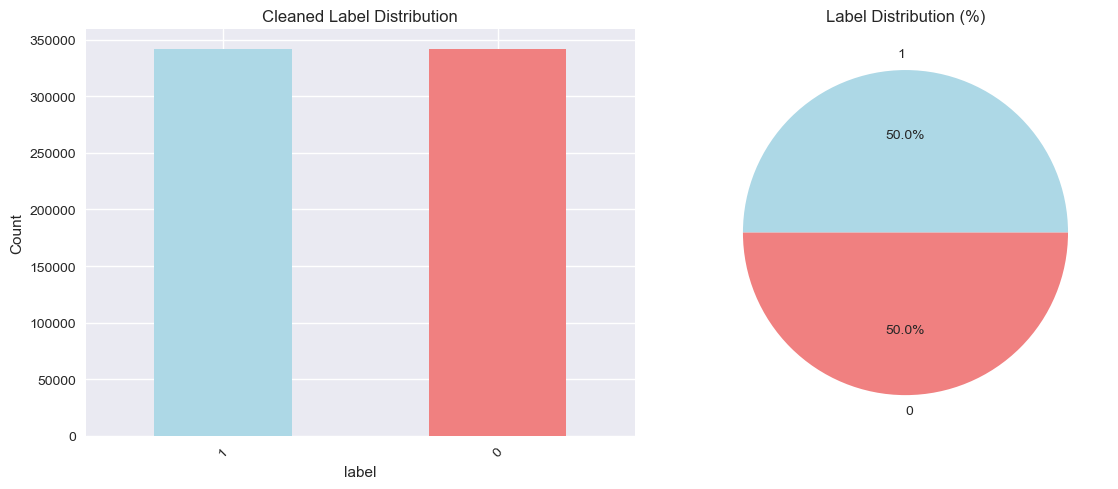

Class imbalance ratio: 1.00


In [173]:
label_counts = train_df['label'].value_counts()
print(label_counts)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Cleaned Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
plt.title('Label Distribution (%)')
plt.tight_layout()
plt.savefig('cleaned_label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class imbalance ratio: {label_counts[1] / label_counts[0]:.2f}")

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Traffic statistics</h3>
</div>

Traffic Statistics Summary:
            duration     orig_bytes     resp_bytes      orig_pkts  \
count  684122.000000  684122.000000  684122.000000  684122.000000   
mean        0.916579       1.130389       3.282966       1.680178   
std         2.567670      11.793899      53.452369       2.016219   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       1.000000   
50%         0.000000       0.000000       0.000000       1.000000   
75%         2.998539       0.000000       0.000000       3.000000   
max       245.999785    2202.000000    8991.000000      60.000000   

           resp_pkts  
count  684122.000000  
mean        0.192389  
std         2.166747  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        75.000000  


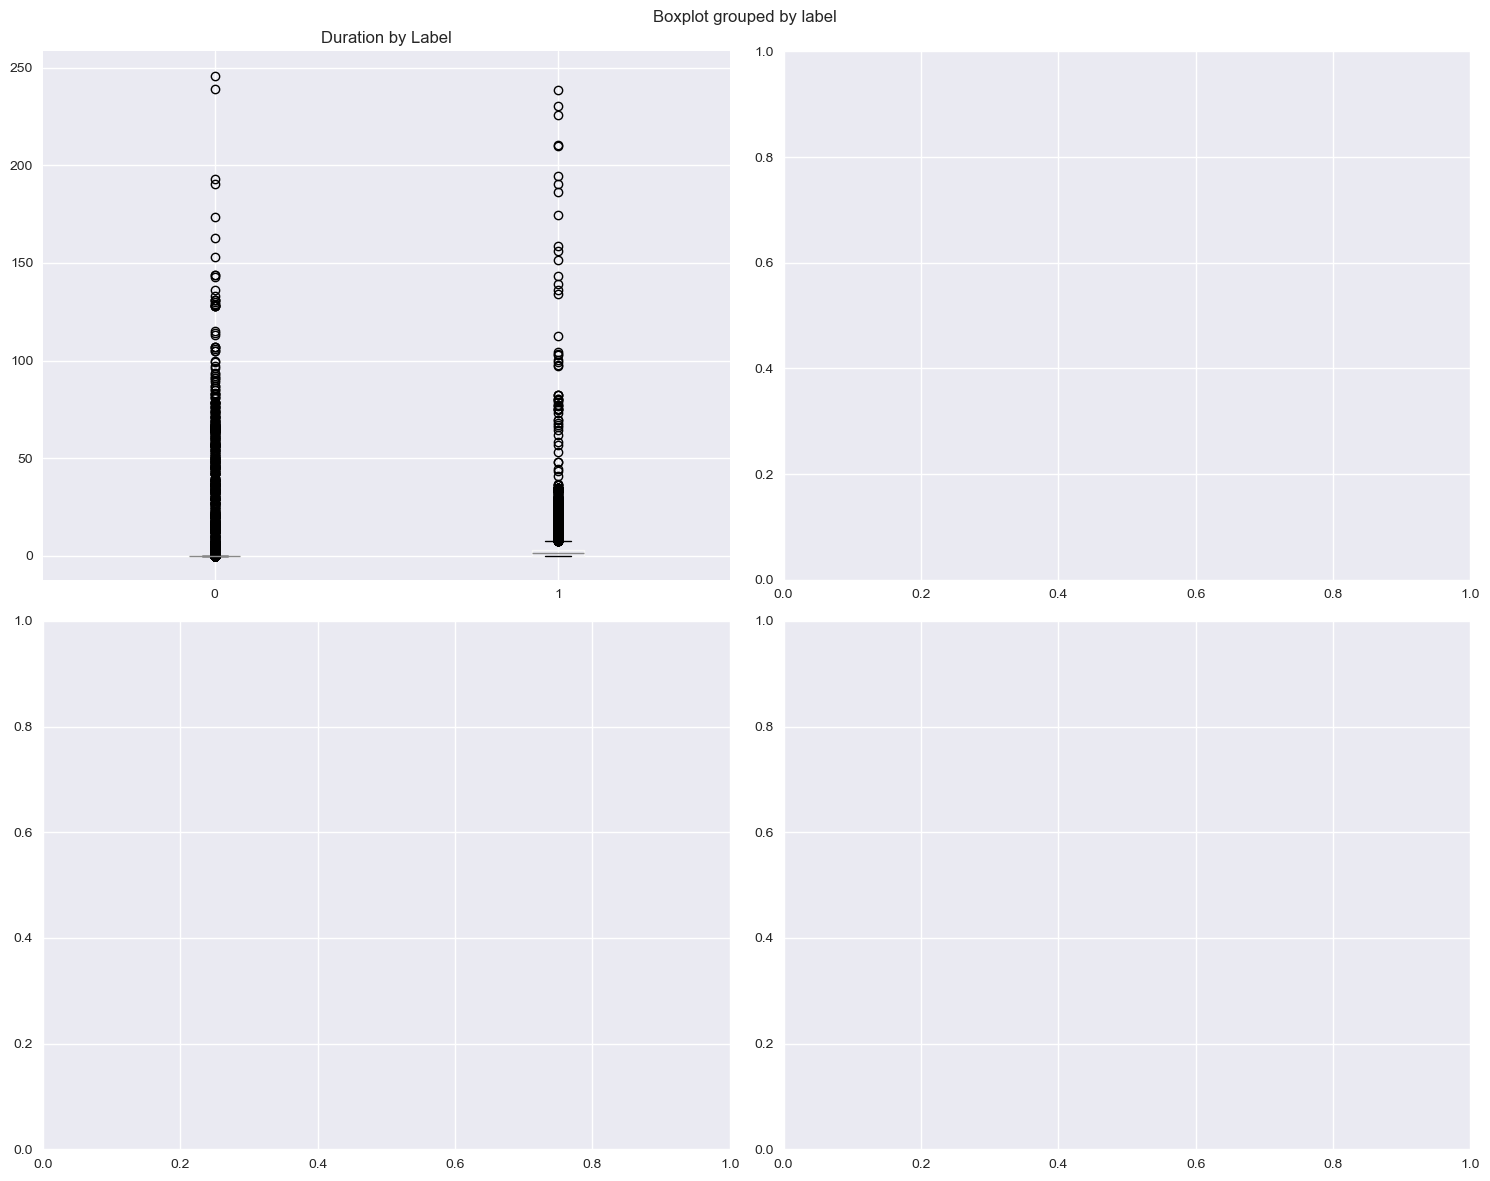

In [174]:
traffic_cols = ['duration', 'orig_bytes', 'resp_bytes', 'total_bytes', 'orig_pkts', 'resp_pkts', 'total_packets', 'bytes_per_packet']

available_traffic_cols = [col for col in traffic_cols if col in train_df.columns]
if available_traffic_cols:
    print("Traffic Statistics Summary:")
    print(train_df[available_traffic_cols].describe())
    
    # Plot traffic statistics by label
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Traffic Statistics by Label (Cleaned)', fontsize=16)
    
    for i, col in enumerate(['duration', 'total_bytes', 'total_packets', 'bytes_per_packet']):
        if col in train_df.columns:
            row, col_idx = i // 2, i % 2
            train_df.boxplot(column=col, by='label', ax=axes[row, col_idx])
            axes[row, col_idx].set_title(f'{col.title()} by Label')
            axes[row, col_idx].set_xlabel('')
    plt.tight_layout()
    plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation analysis</h3>
</div>

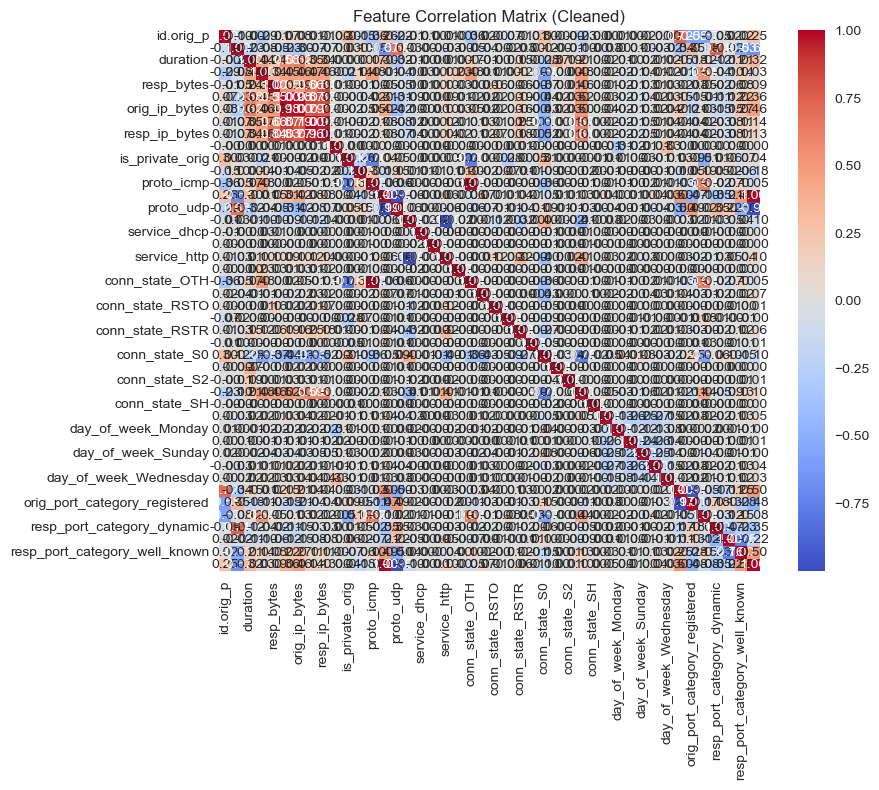

In [175]:
correlation_matrix = train_df[X_train.columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix (Cleaned)')
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Scaling and Train-Test Split</h3>
</div>

In [ ]:
# X = df.drop(columns=['label'])
# y = df['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_res)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Cross Validation</h1>
    <ul>
        <li>XGBoost</li>
        <li>Random Forest</li>
        <li>LiteGBM</li>
        <li>Extra Trees</li>
        <li>Gradient Boost Trees</li>
    </ul>
</div>

In [176]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=100, force_col_wise=True, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    # print(f"\nTraining {name} with PCA features...")
    scores = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring='f1_weighted', n_jobs=-1)
    results.append({
        'Model': name,
        'Mean F1-Score': np.mean(scores),
        'Std Dev': np.std(scores)
    })

results_df = pd.DataFrame(results).sort_values(by='Mean F1-Score', ascending=False)
results_df

/opt/anaconda3/envs/ds_environment/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:36:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/ds_environment/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:36:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/ds_environment/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:36:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/ds_environment/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [01:36:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Par

[LightGBM] [Info] Number of positive: 273649, number of negative: 273648
[LightGBM] [Info] Number of positive: 273648, number of negative: 273649
[LightGBM] [Info] Number of positive: 273649, number of negative: 273649
[LightGBM] [Info] Total Bins 2029
[LightGBM] [Info] Number of data points in the train set: 547297, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000004
[LightGBM] [Info] Start training from score -0.000004
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 547297, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000004
[LightGBM] [Info] Start training from score 0.000004
[LightGBM] [Info] Total Bins 2029
[LightGBM] [Info] Number of data points in the train set: 547298, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 273649, number

,Model,Mean F1-Score,Std Dev
2,Gradient Boosting,0.999985,0.000017
4,LightGBM,0.999716,0.000087
3,XGBoost,0.999579,0.000014
0,Random Forest,0.998836,0.000123
1,Extra Trees,0.997275,0.000115
